# Perlmutter Workload Analysis

This notebook identify representative workload classes (e.g., short CPU-bound jobs, GPU-heavy jobs, data-intensive analytics, multi-node MPI jobs, etc.) from Perlmutter job traces.


We'll implement K-means clustering and use the elbow method to find the optimal number of clusters, with progress visualization using tqdm.

**Imports**

In [3]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
import eda_utils
import clustering_utils
import visualization_utils

**Load Dataset**

In [12]:
print("Loading dataset...")
columns_to_keep = [
    "JobID",           # Unique identifier for each job
    "Account",         # Account/project associated with job (helps identify similar projects)
    "Partition",       # Hardware partition (GPU, shared_GPU, etc.) - indicates resource type
    "QOS",             # Quality of service level (regular, preempt, debug) - indicates priority
    "NCPUS",           # Number of CPUs requested - key resource metric
    "AllocNodes",      # Number of nodes allocated - key resource metric
    "NodeList",        # Specific nodes used - can help identify hardware preferences
    "ElapsedSecs",     # Actual runtime - critical for job characterization
    "WaitTime",        # Time spent in queue - may indicate job priority or resource demands
    "State",           # Job completion status - important for filtering completed jobs
    "TimeLimit",       # User's time estimate - indicates expected complexity
    "ConsumedEnergy",  # Energy usage - good indicator of computational intensity
    "program",         # Department/program - helps group similar jobs
    "sci_cat",         # Scientific category - directly relates to job type
    "ZoneName",        # Zone type (GPU, etc.) - hardware classification
    "ZoneSize",        # Size of the zone - scale of resources
    "Start",           # Time 
    "End",
    "Submit"
]

df = pl.read_csv(
    "../../data/jobs-03_01_2025-03_14_2025.csv",
    has_header=True,
    separator=",",
    try_parse_dates=True,
    columns=columns_to_keep,
    schema_overrides={
        "Start": pl.Datetime,
        "End": pl.Datetime,
        "Submit": pl.Datetime,
        "ElapsedSecs": pl.Int64,
        "WaitTime": pl.Int64,
        "TimeLimit": pl.Int64,
        "ConsumedEnergy": pl.Int64,
        "NCPUS": pl.Int64,
        "AllocNodes": pl.Int64,
        "ChargeFactor": pl.Float64,
        "NerscHours": pl.Float64,
        "RawHours": pl.Float64,
        "MachineHours": pl.Float64,
    },
    null_values=["", "None", "null"] 
)

Loading dataset...


**Exploratory Data Analysis**

In [15]:
eda_utils.describe_dataset(df, target_col='Account')

Dataset shape: (115223, 19)

First 5 rows:


JobID,Account,Partition,QOS,Start,End,NCPUS,AllocNodes,NodeList,ElapsedSecs,Submit,WaitTime,State,TimeLimit,ConsumedEnergy,program,sci_cat,ZoneName,ZoneSize
str,str,str,str,datetime[μs],datetime[μs],i64,i64,str,i64,datetime[μs],i64,str,i64,i64,str,str,str,i64
"""36353606""","""m4319_g""","""gpu_ss11""","""gpu_regular""",2025-03-01 03:50:21,2025-03-01 07:59:59,128,1,"""nid003629""",14978,2025-02-28 10:20:25,62996,"""COMPLETED""",21600,15977100,"""ASCR""","""Data Analytics and Machine Lea…","""gpu""",1792
"""36353609""","""m4319_g""","""gpu_ss11""","""gpu_regular""",2025-03-01 04:09:51,2025-03-01 07:59:59,128,1,"""nid003721""",13808,2025-02-28 10:20:34,64157,"""COMPLETED""",21600,15562022,"""ASCR""","""Data Analytics and Machine Lea…","""gpu""",1792
"""36353612""","""m4319_g""","""gpu_ss11""","""gpu_regular""",2025-03-01 04:33:19,2025-03-01 07:59:59,128,1,"""nid004017""",12400,2025-02-28 10:20:42,65557,"""COMPLETED""",21600,15985030,"""ASCR""","""Data Analytics and Machine Lea…","""gpu""",1792
"""35945562""","""m542_g""","""gpu_ss11""","""gpu_regular""",2025-03-01 00:35:21,2025-03-01 03:00:13,128,1,"""nid002948""",8692,2025-02-17 19:09:15,969966,"""COMPLETED""",28800,6142507,"""BES_MATSCI""","""Condensed Matter""","""gpu""",1792
"""35872145_117""","""m2757_g""","""gpu_ss11""","""gpu_regular""",2025-03-01 00:39:28,2025-03-01 00:54:20,256,2,"""nid[002352,002513]""",892,2025-02-15 02:01:32,1204676,"""COMPLETED""",14400,1355753,"""BES_MATSCI""","""Materials Science""","""gpu""",1792



Data Statistics:


statistic,JobID,Account,Partition,QOS,Start,End,NCPUS,AllocNodes,NodeList,ElapsedSecs,Submit,WaitTime,State,TimeLimit,ConsumedEnergy,program,sci_cat,ZoneName,ZoneSize
str,str,str,str,str,str,str,f64,f64,str,f64,str,f64,str,f64,f64,str,str,str,f64
"""count""","""115223""","""115223""","""114748""","""115223""","""115223""","""115223""",114748.0,114748.0,"""115223""",115223.0,"""114748""",114748.0,"""114748""",114748.0,107181.0,"""115131""","""115131""","""103533""",103533.0
"""null_count""","""0""","""0""","""475""","""0""","""0""","""0""",475.0,475.0,"""0""",0.0,"""475""",475.0,"""475""",475.0,8042.0,"""92""","""92""","""11690""",11690.0
"""mean""",null,null,null,null,"""2025-03-07 04:55:39.841811""","""2025-03-07 06:33:41.719179""",310.074041,2.636665,null,5882.31459,"""2025-03-06 03:53:52.681162""",90502.671027,null,19571.704779,2.8134e7,null,null,null,1724.463736
"""std""",null,null,null,null,null,null,2149.777727,16.770595,null,33289.319301,null,365077.091729,null,101590.967393,3.8507e8,null,null,null,337.288432
"""min""","""26227560""","""alice_g""","""cron""","""RESERVE""","""2025-03-01 00:00:03""","""2025-03-01 00:00:21""",2.0,1.0,"""login01""",0.0,"""2024-11-12 06:33:30""",0.0,"""CANCELLED by 100018""",60.0,0.0,"""ALCC_BASE""","""Accelerator Science""","""gpu""",40.0
"""25%""",null,null,null,null,"""2025-03-04 13:38:01""","""2025-03-04 14:38:10""",32.0,1.0,null,65.0,"""2025-03-03 21:08:14""",498.0,null,1740.0,39070.0,null,null,null,1792.0
"""50%""",null,null,null,null,"""2025-03-06 12:26:14""","""2025-03-06 14:23:17""",128.0,1.0,null,581.0,"""2025-03-05 23:15:57""",14295.0,null,5400.0,501604.0,null,null,null,1792.0
"""75%""",null,null,null,null,"""2025-03-10 07:09:37""","""2025-03-10 09:28:29""",128.0,1.0,null,2419.0,"""2025-03-09 23:13:15""",62378.0,null,14400.0,2.401031e6,null,null,null,1792.0
"""max""","""RESERVE:2025-03-13:1791:root:r…","""xpress_g""","""urgent_gpu_ss11""","""workflow""","""2025-03-13 23:59:38""","""2025-04-18 01:40:44""",145920.0,1140.0,"""nid[200508-200509]""",3.436844e6,"""2025-03-13 23:59:37""",1.045599e7,"""TIMEOUT""",7.776e6,3.9404e10,"""Vendor""","""Visualization""","""other""",1792.0



Account Distribution:


Account,count
str,u32
"""m4632_g""",13
"""m3706_g""",18
"""m4129_g""",262
"""m3210_g""",84
"""m4302_g""",5
…,…
"""m4904_g""",1
"""mp363_g""",1
"""nguest_g""",4


**Data Visualization**

In [16]:
# visualization_utils.plot_pairplot(df, hue='Account', title='Pairplot of Iris Dataset Features');

**Data Preprocessing**

In [17]:
# Standardize the features (excluding the target column)
scaled_df, scaler = eda_utils.standardize_features(df, exclude_cols=['species'])
print("Standardized Features:")
display(scaled_df.head())

# Get standardized data for clustering
X = scaled_df.to_numpy()


ValueError: could not convert string to float: 'RESERVE:2025-03-01:1734:ndk:e3sm:perlmutter gpu'

**Elbow Method**


In [ ]:
k_range = range(1, 11)
inertias, times = clustering_utils.find_optimal_k(X, k_range=k_range, verbose=True)

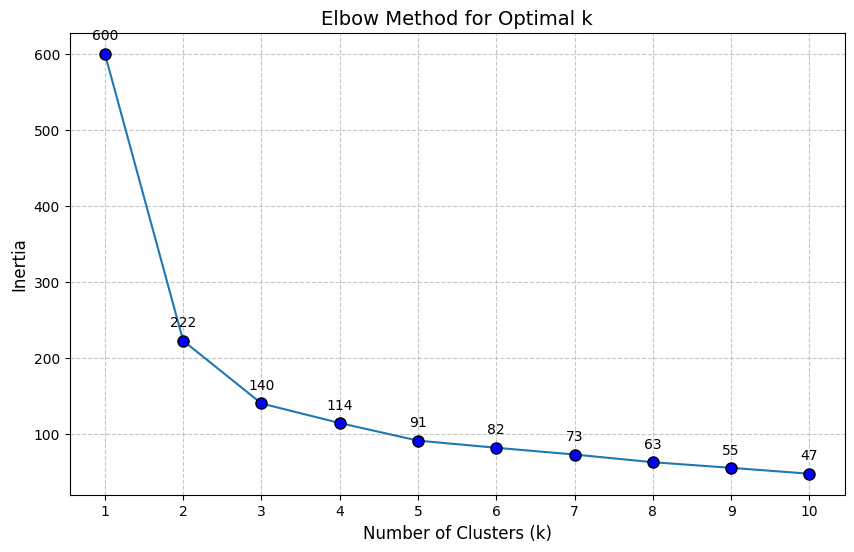

In [12]:
visualization_utils.plot_elbow_method(k_range, inertias, annotate=True);

**Clustering with Optimal K**

In [13]:
# Apply KMeans clustering with the optimal number of clusters
optimal_k = 3  # Based on the elbow method
labels, centers, n_clusters = clustering_utils.apply_clustering(
    X, algorithm="kmeans", params={"n_clusters": optimal_k}
)

# Add cluster labels to the original dataframe
result_df = df.with_columns(pl.Series(name="cluster", values=labels))

# Display results
print("Clustering Results:")
display(result_df.head())

# Compare clusters with original species
print("\nCluster vs. Species Distribution:")
display(result_df.group_by(['species', 'cluster']).agg(pl.len().alias('count')))


Clustering Results:


sepal_length,sepal_width,petal_length,petal_width,species,cluster
f64,f64,f64,f64,i64,i32
5.1,3.5,1.4,0.2,0,1
4.9,3.0,1.4,0.2,0,1
4.7,3.2,1.3,0.2,0,1
4.6,3.1,1.5,0.2,0,1
5.0,3.6,1.4,0.2,0,1



Cluster vs. Species Distribution:


species,cluster,count
i64,i32,u32
1,2,11
2,0,14
1,0,39
0,1,50
2,2,36


In [ ]:
X_pca = visualization_utils.reduce_dimensions(X, method="pca", n_components=2)
centers_pca = visualization_utils.reduce_dimensions(centers, method="pca", n_components=2)

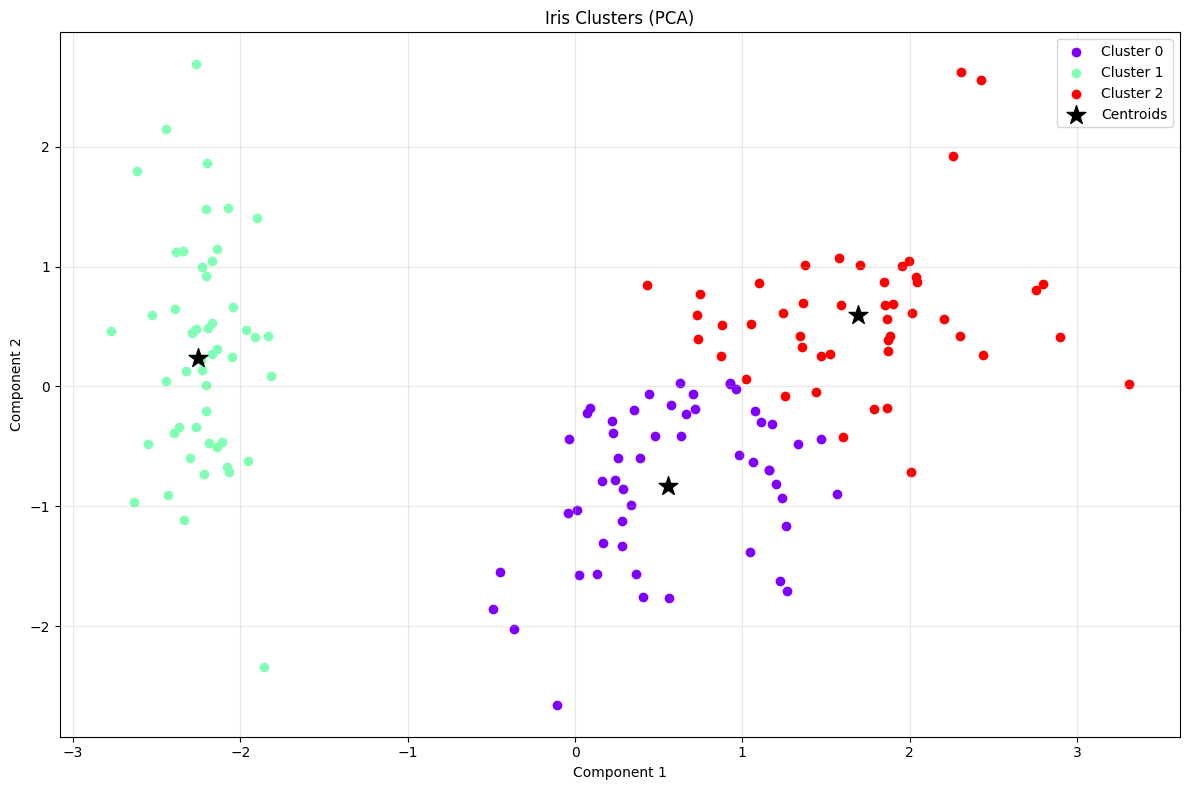

In [16]:
visualization_utils.plot_clusters_mpl(
    X_pca, labels, centers_pca, 
    title='Iris Clusters (PCA)'
);


**Visualization**

In [ ]:
fig = visualization_utils.plot_clusters_plotly(
    X_pca, labels, centers_pca,
    point_labels=result_df['species'].to_list(),
    title='Interactive Iris Clusters (PCA)'
)
fig.show()


In [18]:
X_pca_3d = visualization_utils.reduce_dimensions(X, method="pca", n_components=3)
centers_pca_3d = visualization_utils.reduce_dimensions(centers, method="pca", n_components=3)

fig_3d = visualization_utils.plot_clusters_plotly(
    X_pca_3d, labels, centers_pca_3d,
    point_labels=result_df['species'].to_list(),
    title='Interactive Iris Clusters (PCA 3D)'
)
fig_3d.show()